In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy import interpolate

In [2]:
def spectrum(R,h,hdu):
    n = len(hdu)
    primary_header = hdu[0].header
    
    Rmin = primary_header['rmin']
    Rmax = primary_header['rmax']
    dimR = primary_header['dimR']
    stepR = round((Rmax-Rmin)/dimR,1)
    
    zmin = primary_header['zmin'] 
    zmax = primary_header['zmax']
    dimz = primary_header['dimz']
    stepz = round((zmax-zmin)/dimz,2)
    
    R_i = int(np.round((R-Rmin)/stepR))
    h_i = int(np.round((h-zmin)/stepz))

    for i in range(1,n):
        if hdu[i].header['A'] == 0 and hdu[i].header['EXTRA'] == 1:
            ext_pos = hdu[i].data[h_i,R_i,:]     #z,r,E (lo pone en el header primario)
        elif hdu[i].header['Z_'] == -1 and hdu[i].header['SEC'] == 0 and hdu[i].header['DM'] == 0:
            prim_elec = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 0 and hdu[i].header['SEC'] == 1 and hdu[i].header['Z_'] == 1:
            sec_pos = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == -1 and hdu[i].header['A'] == 0 and hdu[i].header['SEC'] == 1:
            sec_elec = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == 1 and hdu[i].header['A'] == 1 and hdu[i].header['SEC'] == 0:
            prim_prot = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['Z_'] == 1 and hdu[i].header['A'] == 1 and hdu[i].header['SEC'] == 1:
            sec_prot = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 2 and hdu[i].header['Z_'] == 1:
            H2 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 4 and hdu[i].header['Z_'] == 2:
            He = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 10 and hdu[i].header['Z_'] == 5:
            B10 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 11 and hdu[i].header['Z_'] == 5:
            B11 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 12 and hdu[i].header['Z_'] == 6:
            C12 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 13 and hdu[i].header['Z_'] == 6:
            C13 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 14 and hdu[i].header['Z_'] == 6:
            C14 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 16 and hdu[i].header['Z_'] == 8:
            O16 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 17 and hdu[i].header['Z_'] == 8:
            O17 = hdu[i].data[h_i,R_i,:]
        elif hdu[i].header['A'] == 18 and hdu[i].header['Z_'] == 8:
            O18 = hdu[i].data[h_i,R_i,:]
        #    Si = hdu[i].data[h_i,R_i,:]
    return ext_pos, sec_pos, prim_elec, sec_elec, prim_prot, sec_prot, He, B10, B11, C12, C13, C14, O16, O17, O18


In [3]:
file = 'output/NFW.fits.gz'

hdulist = fits.open(file)

prihdr = hdulist[0].header
n_ext = len(hdulist)

table_hdu = hdulist[0]
table_header = table_hdu.header

emin   = table_header['ekmin']
ek_fac = table_header['ekin_fac']
dimE   = table_header['dimE']

E = [emin*(ek_fac**i) for i in range(0,dimE)]
E = np.array(E)

Rmin = table_header['rmin'] #kpc
Rmax = table_header['rmax']
dimR = table_header['dimR']

R = np.linspace(Rmin,Rmax,dimR)
stepR = round((Rmax-Rmin)/dimR,1)

zmin = table_header['zmin'] 
zmax = table_header['zmax']
dimz = table_header['dimz']
z = np.linspace(zmin,zmax,dimz)
stepz = round((zmax-zmin)/dimz,2)

print('Rmin =',Rmin,', Rmax =',Rmax,', stepR =',stepR)
print('zmin =',zmin,', zmax =',zmax,', stepz =',stepz)

ep, sp, pe, se, ppr, spr, He, B10, B11, C12, C13, C14, O16, O17, O18 = spectrum(8.3, 0, hdulist)

Rmin = 0.0 , Rmax = 12.0 , stepR = 0.1
zmin = -18.0 , zmax = 18.0 , stepz = 0.3


In [4]:
Elog = np.log(E)
phi = 0.58
def lepton_modulation(E, Elog, spectrum, potential, m):
    dimE = len(E)
    spectrum_mod = np.zeros(int(dimE))
    A = ((E + m)**2 - m**2) / (((E + m) + potential)**2 - m**2)    
    F = interpolate.InterpolatedUnivariateSpline(Elog, spectrum)
    Elog_shifted = np.zeros(dimE)
    for i in range(dimE):
        Elog_shifted[i] = np.log(E[i] + potential)
    spectrum_mod = A * F(Elog_shifted)
    return spectrum_mod

def proton_modul(E, flux, m, Z, A, phi_nuc, Charge_sign=False, phi_n= 0.7, fluxerr = 0):
        if Charge_sign == True:         
            R0 = 1.
            R = (A/Z) * np.sqrt(E**2 + 2*m*E)
            phi_ = phi_n
            phi_n = phi_nuc + phi_*(R0/R)
            En = E + (Z/A)*phi_n
            mod = E * (E + 2*m) / ((E + (Z/A)*phi_n + m)**2 - m**2)
            flux_mod = np.interp(En, E, flux)*mod
            
        else:
            En = E + (Z/A)*phi_nuc
            mod = E * (E + 2*m) / ((E + (Z/A)*phi_nuc + m)**2 - m**2)
            flux_mod = np.interp(En, E, flux)*mod
        
        if fluxerr != 0: 
            fluxerr_mod = np.interp(En, E, fluxerr)*mod
            return np.array(flux_mod), np.array(fluxerr_mod)
          
        return np.array(flux_mod)#, np.array(fluxerr_mod)
    
def Rig_to_En(R, A, Z, flux, errflux):
        m = 0.9315

        Rmean = np.array(R)
        
        #M = A*m
        #T = (np.sqrt((Z*Rmean)**2 + M**2) - M )/A       # T is the Emean!!
        
        T = (np.sqrt((Z*Rmean/A)**2 + m**2) - m )
        dRdE = (A/Z)*(np.array(T)+m)/np.sqrt((np.array(T)**2) + 2. * np.array(T)*m)
        Flux = dRdE * np.array(flux)
        ErrFlux = dRdE * np.array(errflux)
        

        return T, Flux, ErrFlux

def En_to_Rig(E, A, Z, flux, errflux):
        m = 0.9315
            
        Emean = np.array(E)
        R = (A/Z) * np.sqrt(Emean**2 + 2*m*Emean)
        dEdR = (Z/A)**2 * R/((R*Z/A)**2 + m**2)
        Flux = dEdR * np.array(flux)
        ErrFlux = dEdR * np.array(errflux)
        
        return R, Flux, ErrFlux

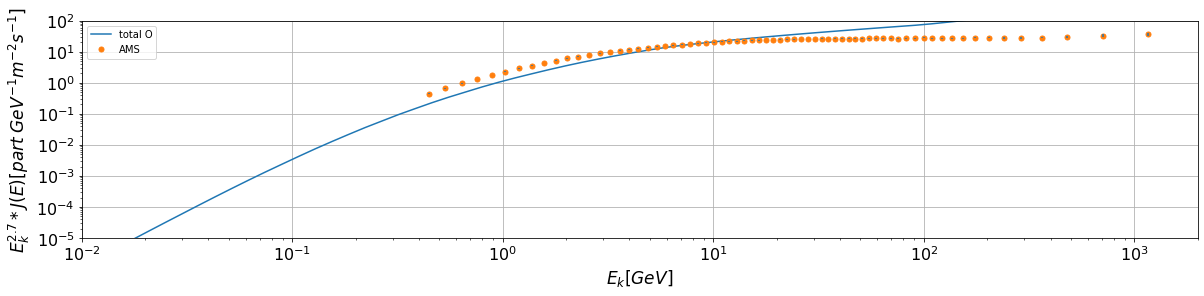

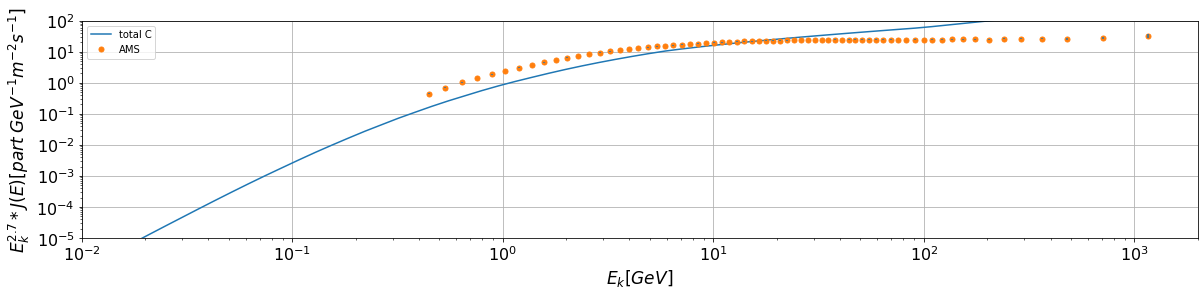

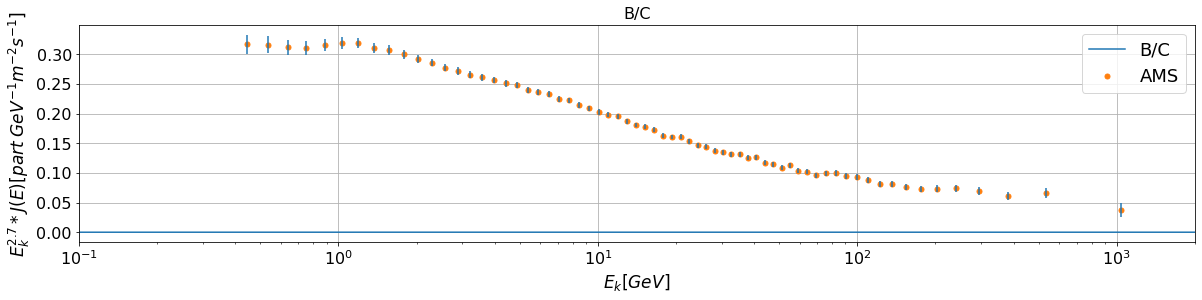

In [5]:
m_O16 = 0.9315 * 16
m_O17 = 0.9315 * 17
m_O18 = 0.9315 * 18
O16_c = proton_modul(E, O16, m_O16, 8, 16, phi)
O17_c = proton_modul(E, O17, m_O17, 8, 17, phi)
O18_c = proton_modul(E, O18, m_O18, 8, 18, phi)
O_exp = np.loadtxt('Data_files/manuel/O_AMS.txt',usecols=[0,3,4,5])
E_O = O_exp[:,0]
flux_O = O_exp[:,1]
err_O = O_exp[:,2]


plt.figure(figsize=(20,4))
plt.loglog(E,(O16_c+O17_c+O18_c)*E**2.7,label = 'total O')
plt.loglog(E_O,flux_O*E_O**2.7,'o',markersize = 5, label = 'AMS')
plt.errorbar(E_O,flux_O*E_O**2.7, yerr = err_O*E_O**2.7, fmt = 'none')
plt.ylabel(r'$E_k^{2.7} * J(E)[part \; GeV^{-1} m^{-2} s^{-1}]$', fontsize=17)
plt.xlabel(r'$E_k [GeV]$', fontsize = 17)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.ylim(1e-5,1e2)
plt.xlim(1e-2,2e3)
plt.legend()
plt.grid()
plt.show()



m_B10 = 0.9315 * 10
m_B11 = 0.9315 * 11
m_C12 = 0.9315 * 12
m_C13 = 0.9315 * 13
m_C14 = 0.9315 * 14
B10_c = proton_modul(E, B10, m_B10, 5, 10, phi)
B11_c = proton_modul(E, B11, m_B11, 5, 11, phi)
C12_c = proton_modul(E, C12, m_C12, 6, 12, phi)
C13_c = proton_modul(E, C13, m_C13, 6, 13, phi)
C14_c = proton_modul(E, C14, m_C14, 6, 14, phi)



C_exp = np.loadtxt('Data_files/manuel/C_AMS.txt',usecols=[0,3,4,1,2])
E_C = C_exp[:,0]
flux_C = C_exp[:,1]
err_C = C_exp[:,2]

BC_exp = np.loadtxt('Data_files/manuel/B_C_ratio.txt',usecols=[0,3,4,5])
E_BC = BC_exp[:,0]
flux_BC = BC_exp[:,1]
err_BC = [BC_exp[:,2],BC_exp[:,3]]

plt.figure(figsize=(20,4))
plt.loglog(E,(C12_c+C13_c+C14_c)*E**2.7,label = 'total C')
plt.loglog(E_C,flux_C*E_C**2.7,'o',markersize = 5, label = 'AMS')
plt.errorbar(E_C,flux_C*E_C**2.7, yerr = err_C*E_C**2.7, fmt = 'none')
plt.ylabel(r'$E_k^{2.7} * J(E)[part \; GeV^{-1} m^{-2} s^{-1}]$', fontsize=17)
plt.xlabel(r'$E_k [GeV]$', fontsize = 17)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.ylim(1e-5,1e2)
plt.xlim(1e-2,2e3)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20,4))
plt.plot(E,(B10_c+B11_c)/(C12_c+C13_c+C14_c),label = 'B/C')
plt.plot(E_BC,flux_BC,'o',markersize = 5, label = 'AMS')
plt.errorbar(E_BC,flux_BC, yerr = err_BC, fmt = 'none')
plt.ylabel(r'$E_k^{2.7} * J(E)[part \; GeV^{-1} m^{-2} s^{-1}]$', fontsize=17)
plt.xlabel(r'$E_k [GeV]$', fontsize = 17)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.title('B/C', fontsize = 16)
#plt.ylim(1e1,2e4)
plt.xlim(1e-1,2e3)
plt.xscale('log')
plt.legend(fontsize=18)
plt.grid()
plt.show()

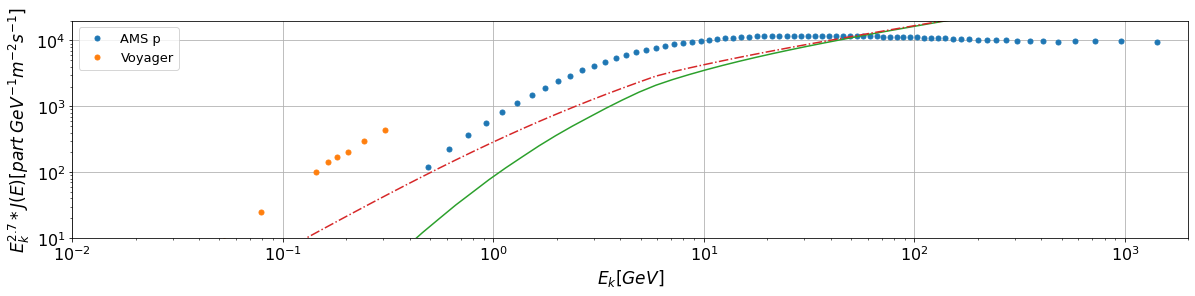

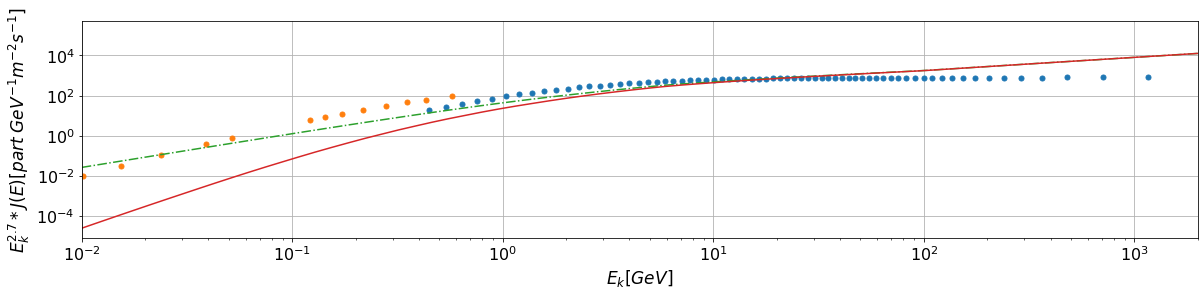

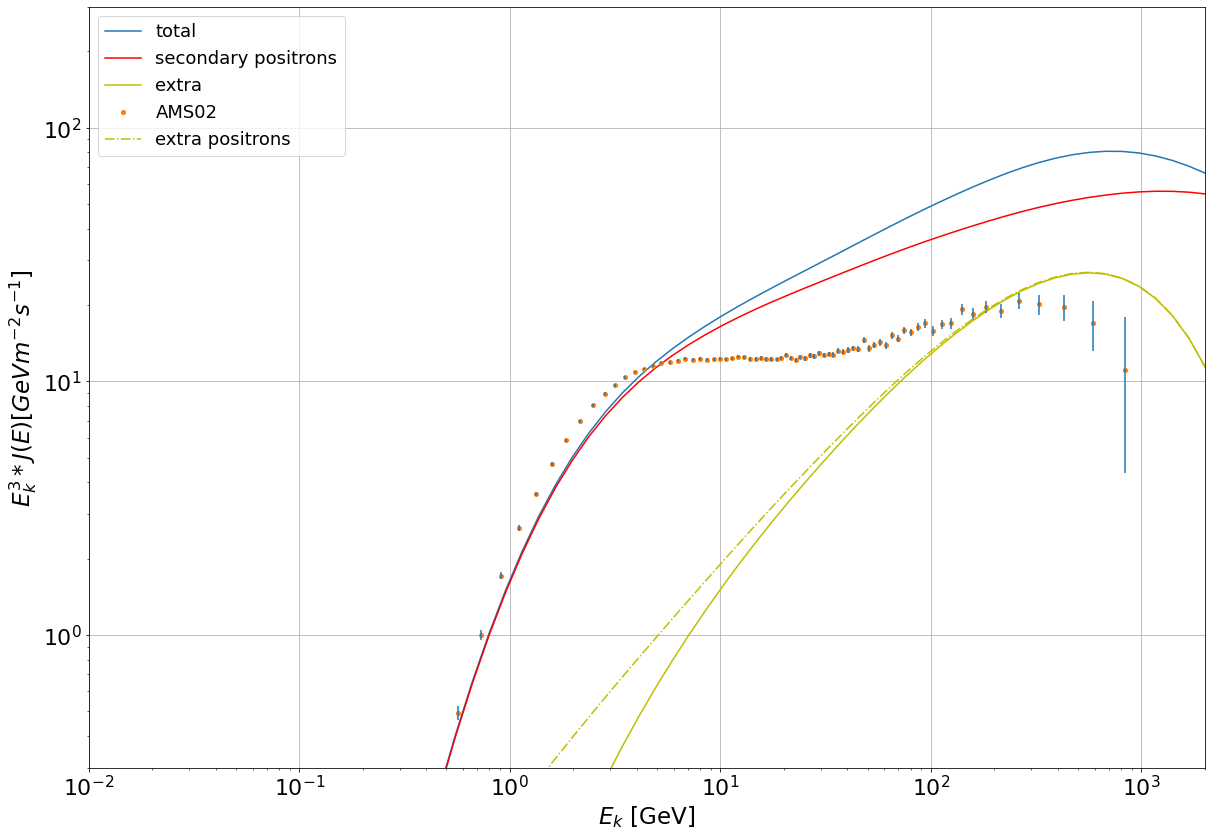

In [6]:
#PROTONES
phi = 0.58
m_p = 0.938


#ppr_c = lepton_modulation(E, Elog, ppr+spr+H2+H3, phi,m_p)
ppr1_c = proton_modul(E, ppr+spr, m_p, 1, 1, phi)
#ppr2_c = proton_modul(E, H2, m_p, 1, 2, phi)
#ppr3_c = proton_modul(E, H3, m_p, 1, 3, phi)
ppr_c = ppr1_c #+ ppr2_c + ppr3_c 


test = np.loadtxt('Data_files/manuel/prot_AMS_2011-2013.dat', usecols = [0,3,8,1,2])
test_voy = np.loadtxt('Data_files/manuel/Voyager1_2012_Proton.dat', usecols = [0,3,8,1,2])

plt.figure(figsize=(20,4))
plt.loglog(test[:,0],test[:,1]*(test[:,0]**2.7),'o',markersize = 5, label = 'AMS p')
plt.loglog(test_voy[:,0],test_voy[:,1]*(test_voy[:,0]**2.7),'o',markersize = 5, label = 'Voyager')
#plt.loglog(E,(ppr+spr+H2+H3)*E**(2.7),'--', label='protons')
plt.loglog(E,ppr_c*E**(2.7))
plt.loglog(E,ppr*E**(2.7),'-.')
plt.legend(fontsize=13)
#plt.title('protons')
plt.ylabel(r'$E_k^{2.7} * J(E)[part \; GeV^{-1} m^{-2} s^{-1}]$', fontsize=17)
plt.xlabel(r'$E_k [GeV]$', fontsize = 17)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
plt.ylim(1e1,2e4)
plt.xlim(1e-2,2e3)
plt.grid()
#plt.savefig('protons.jpg')
plt.show()



m_he = 4 * m_p

he_c = proton_modul(E, He, m_he, 2, 4, phi)

he_voy = np.loadtxt('Data_files/manuel/Voyager1_Helium.txt',usecols=[2,3,4,0,1])
E_he_voy = he_voy[:,0]/1e3
flux_he_voy = he_voy[:,1]*1e3

he_ams = np.loadtxt('Data_files/manuel/He_AMS_2011-2013.dat',usecols=[0,3,8,1,2])
E_he_ams = he_ams[:,0]
flux_he_ams = he_ams[:,1]


plt.figure(figsize=(20,4))
plt.loglog(E_he_ams,flux_he_ams*E_he_ams**(2.7),'o',markersize = 5, label = 'AMS He')
plt.loglog(E_he_voy,flux_he_voy*E_he_voy**(2.7),'o',markersize = 5, label = 'Voyager')
plt.loglog(E,He*E**(2.7),'-.')
plt.loglog(E,he_c*E**(2.7),'-')
plt.ylabel(r'$E_k^{2.7} * J(E)[part \; GeV^{-1} m^{-2} s^{-1}]$', fontsize=17)
plt.xlabel(r'$E_k [GeV]$', fontsize = 17)
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
#plt.ylim(1e1,2e4)
plt.xlim(1e-2,2e3)
plt.grid()
plt.show()



T_r_e = 0.511 / 1000 #GeV
m_e = 0.000510998918 

ep_c = lepton_modulation(E, Elog, ep/2, phi, m_e)
sp_c = lepton_modulation(E, Elog, sp, phi, m_e)
se_c = lepton_modulation(E, Elog, se, phi, m_e)
positrons_c = lepton_modulation(E, Elog, (ep/2)+sp, phi, m_e)

pos_exp = np.loadtxt('Data_files/manuel/positron_data.txt',usecols=[5,8,9])
E_pos = pos_exp[:,0]
flux_pos = pos_exp[:,1]
err_pos = pos_exp[:,2]

plt.figure(figsize=(20,14))
plt.loglog(E,positrons_c*E**3,label='total')
plt.loglog(E,sp_c*E**3,'r',label='secondary positrons')
plt.loglog(E,ep_c*E**3, 'y',label='extra')
plt.loglog(E_pos,flux_pos*(E_pos**3),'o', markersize=4, label ='AMS02')
plt.errorbar(E_pos,flux_pos*(E_pos**3), yerr = err_pos*(E_pos**3), fmt = 'none')
#plt.loglog(E,sp*E**3,'r-.',label='secondary positrons')
plt.loglog(E,(ep/2)*E**3,'y-.',label='extra positrons')
plt.legend(fontsize = 18)
#plt.title('Positrons spectrum')
plt.ylabel(r'$E_k^3 * J(E)[GeV m^{-2} s^{-1}]$', fontsize = 23)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 23)
plt.yticks(fontsize = 22)
plt.xticks(fontsize = 22)
plt.xlim(1e-2,2e3)
plt.ylim(3e-1,3e2)
plt.grid()
plt.show()

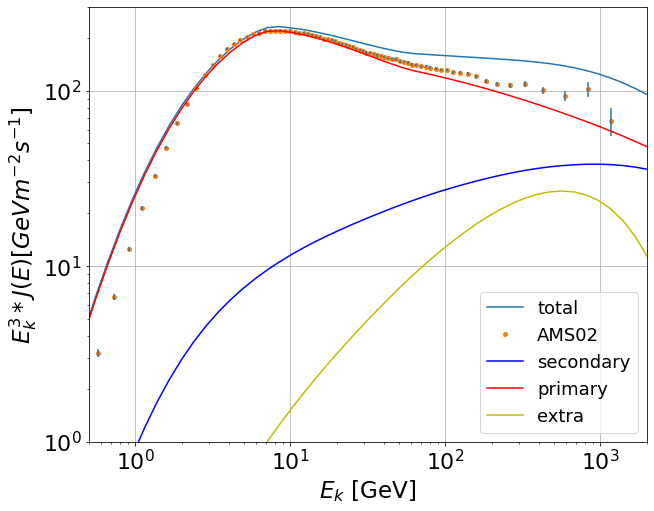

In [7]:
#ELECTRONES

pe_c = lepton_modulation(E, Elog, pe, phi, m_e)
se_c = lepton_modulation(E, Elog, se, phi, m_e)

electrons_c = se_c + pe_c + ep_c# + pe_1_c
elec_exp = np.loadtxt('Data_files/manuel/electron_data.txt',usecols=[5,8,9])
E_e = elec_exp[:,0]
flux_e = elec_exp[:,1]
err_e = elec_exp[:,2]

plt.figure(figsize=(10,8))
plt.loglog(E,electrons_c*E**3,label='total')
plt.loglog(E_e,flux_e*(E_e**3),'o',markersize=4,label = 'AMS02')
plt.errorbar(E_e,flux_e*(E_e**3), yerr = err_e*(E_e**3), fmt = 'none')
plt.loglog(E,se_c*E**3,'b',label='secondary')
plt.loglog(E,pe_c*E**3, 'r',label='primary')
plt.loglog(E,ep_c*E**3, 'y',label='extra')
plt.legend(fontsize = 18)
#plt.title('Electron spectrum')
plt.ylabel(r'$E_k^3 * J(E)[GeV m^{-2} s^{-1}]$', fontsize = 23)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 23)
plt.yticks(fontsize = 22)
plt.xticks(fontsize = 22)
plt.ylim(1e0,3e2)
plt.xlim(5e-1,2e3)
plt.grid()
#plt.savefig('plots/ele_mcm.jpg')
plt.show()

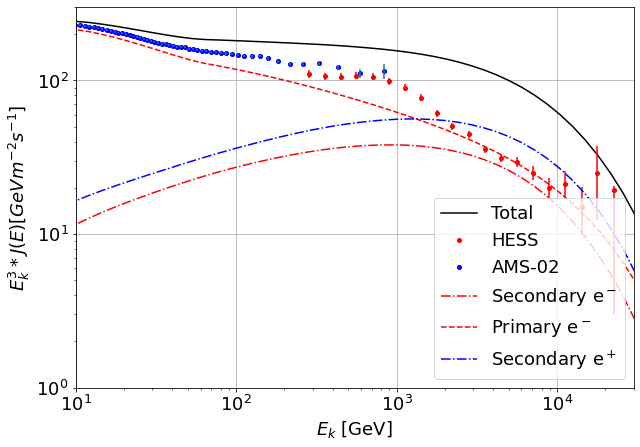

In [8]:
#SUMA ELECTRONES Y POSITRONES

lepton_exp_HESS = np.loadtxt('Data_files/manuel/lepton_flux_HESS.txt',usecols=[0,1,2,3])
E_l_HESS = lepton_exp_HESS[:,0]*1000
flux_l_HESS = lepton_exp_HESS[:,1]
err_l_HESS = np.array((lepton_exp_HESS[:,1]-lepton_exp_HESS[:,2], lepton_exp_HESS[:,3]-lepton_exp_HESS[:,1]))


lepton_exp_AMS = np.loadtxt('Data_files/manuel/lepton_flux_AMS.txt',usecols=[5,8,9])
E_l_AMS = lepton_exp_AMS[:,0]
flux_l_AMS = lepton_exp_AMS[:,1]
err_l_AMS = lepton_exp_AMS[:,2]

plt.figure(figsize=(10,7))
plt.loglog(E,(se_c+sp_c+pe_c)*(E**3),'k',label='Total')
plt.loglog(E_l_HESS,flux_l_HESS,'ro', markersize=4, label = 'HESS') #datos experimentales de la suma
plt.errorbar(E_l_HESS,flux_l_HESS, yerr = err_l_HESS, fmt = 'none', color = 'r')
#plt.loglog(E_l_HESS,flux_l_min,'*',markersize=4)
#plt.loglog(E_l_HESS,flux_l_max,'*',markersize=4)
plt.loglog(E_l_AMS,flux_l_AMS*(E_l_AMS**3),'bo', markersize=4, label='AMS-02') #datos experimentales de la suma
plt.errorbar(E_l_AMS,flux_l_AMS*(E_l_AMS**3), yerr = err_l_AMS*(E_l_AMS**3), fmt = 'none')
plt.loglog(E,se_c*E**3,'r-.',label=r'Secondary e$^-$')
plt.loglog(E,pe_c*E**3, 'r--',label=r'Primary e$^-$')
plt.loglog(E,sp_c*E**3,'b-.',label=r'Secondary e$^+$')
plt.legend(loc = 'lower right', fontsize = 18)
#plt.title('Lepton spectrum')
plt.ylabel(r'$E_k^3 * J(E)[GeV m^{-2} s^{-1}]$', fontsize = 18)
plt.xlabel(r'$E_k$ [GeV]', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylim(1e0,3e2)
plt.xlim(1e1,3e4)
plt.grid()
plt.show()